In [2]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster
import spacy
from datetime import datetime as dt
import pytz
import matplotlib.pyplot as plt 
import numpy as np
import scipy.stats

2022-10-06 14:03:18.558976: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-10-06 14:03:18.559050: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
merged_Tweets_df = pd.read_csv('/home/is/shuntaro-o/dev/disaster_analysis_Twitter/data/Hurricane/merged_data.csv')

In [4]:
estimated_df = pd.read_csv('/home/is/shuntaro-o/dev/disaster_analysis_Twitter/data/Hurricane/estimated_test.csv')

In [5]:
AuthorID_list = merged_Tweets_df['AuthorID'].unique()

In [6]:
merged_Tweets_df["CreateTime"]

0         2019-09-30T05:52:59.000Z
1         2019-09-28T21:32:46.000Z
2         2019-09-07T00:46:41.000Z
3         2019-09-04T22:17:48.000Z
4         2019-09-04T07:10:30.000Z
                    ...           
346288    2019-10-11T04:28:46.000Z
346289    2019-08-16T09:59:14.000Z
346290    2019-08-15T11:36:52.000Z
346291    2019-08-16T03:54:55.000Z
346292    2019-09-23T14:35:09.000Z
Name: CreateTime, Length: 346293, dtype: object

In [7]:
time_list =  merged_Tweets_df['CreateTime'].unique()

In [8]:
y_list = []
m_list = []
d_list = []
ymd_list = []
for time in time_list:
    y_list.append(int(time[0:4]))
    m_list.append(int(time[5:7]))
    d_list.append(int(time[8:10]))
    ymd_list.append(time[0:10])


ユーザーごと

In [9]:
user_sequence = merged_Tweets_df[merged_Tweets_df['AuthorID']==AuthorID_list[10]]
m = folium.Map(location=[35.6, 139.7], zoom_start=7.0)
for index, r in user_sequence.iterrows():
    folium.Marker([r.UserPlase_latitude,r.UserPlase_longitude]).add_to(m)
m

推論分析

In [10]:
estimated_True = estimated_df[estimated_df["code"]==estimated_df["geo_code"]]
estimated_False = estimated_df[estimated_df["code"]!=estimated_df["geo_code"]]

In [11]:
m = folium.Map(location=[35.6, 139.7], zoom_start=7.0)
marker_cluster = MarkerCluster().add_to(m)
for index, r in estimated_True.iterrows():
    folium.Marker([r.UserPlase_latitude,r.UserPlase_longitude]).add_to(marker_cluster)
m

In [12]:
m = folium.Map(location=[35.6, 139.7], zoom_start=7.0)
marker_cluster = MarkerCluster().add_to(m)
for index, r in estimated_False.iterrows():
    folium.Marker([r.UserPlase_latitude,r.UserPlase_longitude]).add_to(marker_cluster)
m

In [13]:

# モデルのロード
nlp = spacy.load("ja_core_news_md")
# 解析対象のテキストa
input_text = "8月に東京に行く"
# モデルに解析対象のテキストを渡す
doc = nlp(input_text)
# 固有表現を抽出
for ent in doc.ents:
    print(ent.text, ent.label_, ent.start_char, ent.end_char)

8月 DATE 0 2
東京 GPE 3 5


In [14]:
sentences_True = estimated_True.Text.values

In [15]:
counter_in_True=0
for text in sentences_True:
    Flag=0
    doc = nlp(text)
    for ent in doc.ents:
        if ent.label_=="GPE":
            Flag=1
        if Flag==1:
            counter_in_True+=1
counter_in_True

339

In [16]:
sentences_False = estimated_False.Text.values

In [17]:
counter_in_False=0
for text in sentences_True:
    Flag=0
    doc = nlp(text)
    for ent in doc.ents:
        if ent.label_=="GPE":
            Flag=1
        if Flag==1:
            counter_in_False+=1
counter_in_False

339

In [18]:
counter_in_False

339

時間分析

１dayごと

In [19]:
time_line_df = pd.read_csv("/home/is/shuntaro-o/dev/disaster_analysis_Twitter/data/Hurricane/split_time.csv")

In [20]:
compare_times = time_line_df.ymd.unique()

In [21]:
compare_times.sort()

In [22]:
tweet_nums_per_day = []
for i in compare_times:
    tweet_nums_per_day.append(len(time_line_df[time_line_df['ymd']==i]))

In [23]:
hour_for_xlabel = []
for i in compare_times:
    hour_for_xlabel.append(str(i)[-2:])

In [24]:
xlabel = []
for i in compare_times:
    xlabel.append('{}/{}'.format(str(i)[4:6],str(i)[6:8]))


In [25]:
len(xlabel)

123

Text(0, 0.5, 'sum_tweets')

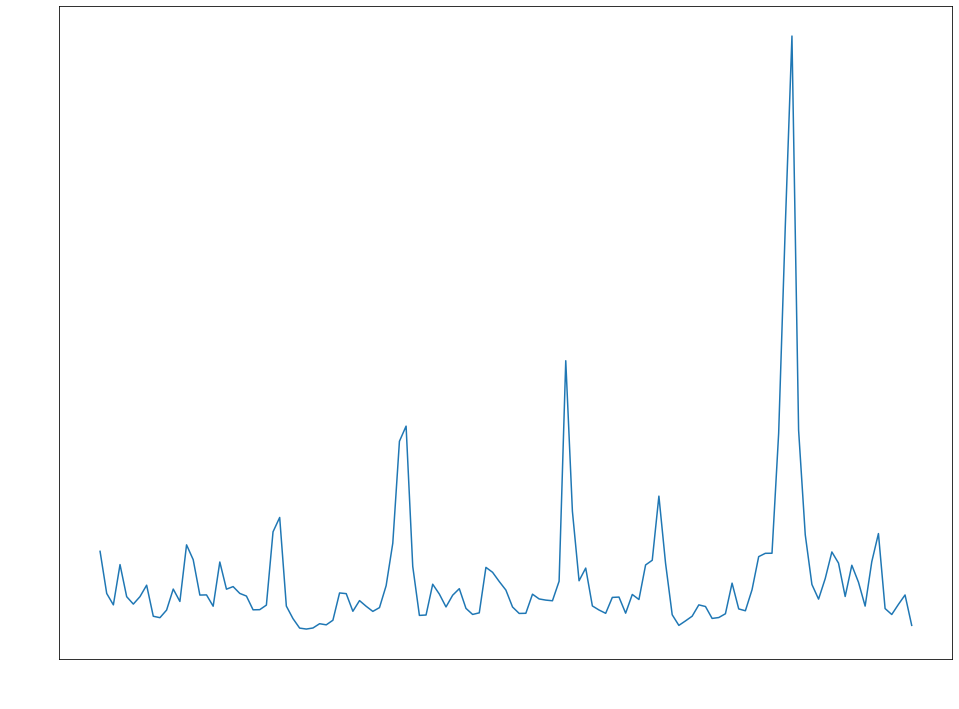

In [26]:
plt.rcParams["figure.figsize"] = (16, 12)
plt.xticks(rotation=30)
plt.tick_params(direction = "inout", length = 5, colors = "white")
plt.xticks(np.arange(0, 123, 10))
plt.plot(xlabel,tweet_nums_per_day)
plt.xlabel("time",color="white")
plt.ylabel("sum_tweets",color="white")

1hourごと
hagibis

In [27]:
compare_times_hour = time_line_df.ymdh.unique()
compare_times_hour.sort()
compare_times_hour = compare_times_hour[2328:2592]

In [28]:
xlabel_hour = []
for i in compare_times_hour:
    xlabel_hour.append('{}/{}/{}'.format(str(i)[4:6],str(i)[6:8],str(i)[8:10]))

In [29]:
tweet_nums_per_hour = []
for i in compare_times_hour:
    tweet_nums_per_hour.append(len(time_line_df[time_line_df['ymdh']==i]))

Text(0, 0.5, 'sum_tweets')

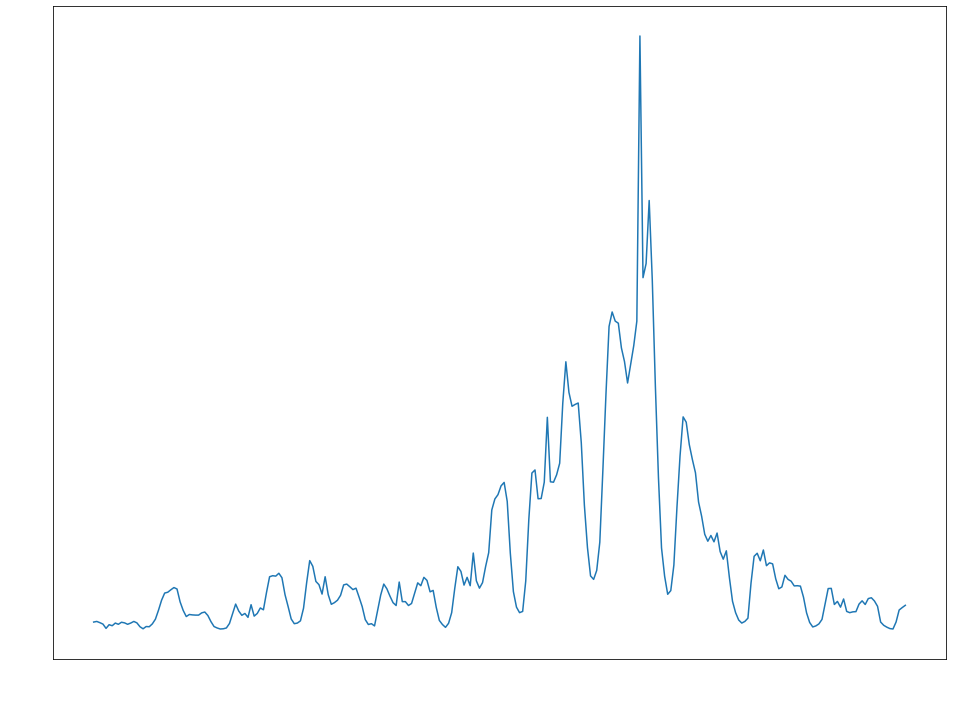

In [30]:
from turtle import color


plt.rcParams["figure.figsize"] = (16, 12)
plt.xticks(rotation=30)
plt.tick_params(direction = "inout", length = 5, colors = "white")
plt.xticks(np.arange(0, 264, 24))
plt.plot(xlabel_hour,tweet_nums_per_hour)
plt.xlabel("time",color="white")
plt.ylabel("sum_tweets",color="white")

#地域ごと

In [31]:
compare_times_hour = time_line_df.ymdh.unique()
compare_times_hour.sort()
compare_times_hour = compare_times_hour[2328:2592]

In [32]:
xlabel_hour = []
for i in compare_times_hour:
    xlabel_hour.append('{}/{}/{}'.format(str(i)[4:6],str(i)[6:8],str(i)[8:10]))

In [33]:
tweet_nums_per_hour_lon_to_130 = []
for i in compare_times_hour:
    tweet_nums_per_hour_lon_to_130.append(len(time_line_df[(time_line_df['ymdh']==i) & (time_line_df['UserPlase_longitude']<=130)]))

In [34]:
tweet_nums_per_hour_lon_to_133 = []
for i in compare_times_hour:
    tweet_nums_per_hour_lon_to_133.append(len(time_line_df[(time_line_df['ymdh']==i) & (time_line_df['UserPlase_longitude']>130)& (time_line_df['UserPlase_longitude']<=133)]))

In [35]:
tweet_nums_per_hour_lon_to_136 = []
for i in compare_times_hour:
    tweet_nums_per_hour_lon_to_136.append(len(time_line_df[(time_line_df['ymdh']==i) & (time_line_df['UserPlase_longitude']>133)& (time_line_df['UserPlase_longitude']<=136)]))

In [36]:
tweet_nums_per_hour_lon_to_139 = []
for i in compare_times_hour:
    tweet_nums_per_hour_lon_to_139.append(len(time_line_df[(time_line_df['ymdh']==i) & (time_line_df['UserPlase_longitude']>136)& (time_line_df['UserPlase_longitude']<=139)]))

In [37]:
tweet_nums_per_hour_lon_to_142 = []
for i in compare_times_hour:
    tweet_nums_per_hour_lon_to_142.append(len(time_line_df[(time_line_df['ymdh']==i) & (time_line_df['UserPlase_longitude']>139)& (time_line_df['UserPlase_longitude']<=142)]))

In [38]:
tweet_nums_per_hour_lon_to_145 = []
for i in compare_times_hour:
    tweet_nums_per_hour_lon_to_145.append(len(time_line_df[(time_line_df['ymdh']==i) & (time_line_df['UserPlase_longitude']>142)& (time_line_df['UserPlase_longitude']<=145)]))

In [39]:
tweet_nums_per_hour_lon_over_145 = []
for i in compare_times_hour:
    tweet_nums_per_hour_lon_over_145.append(len(time_line_df[(time_line_df['ymdh']==i) & (time_line_df['UserPlase_longitude']>145)]))

Text(0, 0.5, 'sum_tweets')

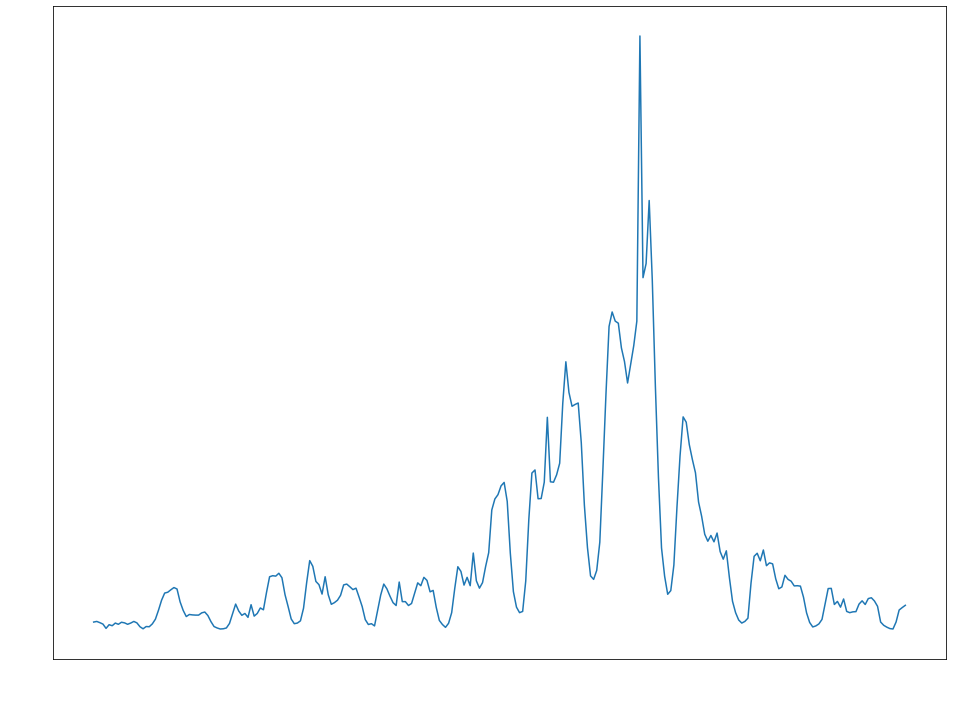

In [40]:
plt.rcParams["figure.figsize"] = (16, 12)
plt.xticks(rotation=30)
plt.tick_params(direction = "inout", length = 5, colors = "white")
plt.xticks(np.arange(0, 264, 24))
plt.plot(xlabel_hour,tweet_nums_per_hour)
plt.xlabel("time",color="white")
plt.ylabel("sum_tweets",color="white")

In [41]:
print(len(xlabel_hour))
print(len(tweet_nums_per_hour))
print(len(tweet_nums_per_hour_lon_to_130))
print(len(tweet_nums_per_hour_lon_to_133))
print(len(tweet_nums_per_hour_lon_to_136))
print(len(tweet_nums_per_hour_lon_to_139))
print(len(tweet_nums_per_hour_lon_to_142))
print(len(tweet_nums_per_hour_lon_over_145))

264
264
264
264
264
264
264
264


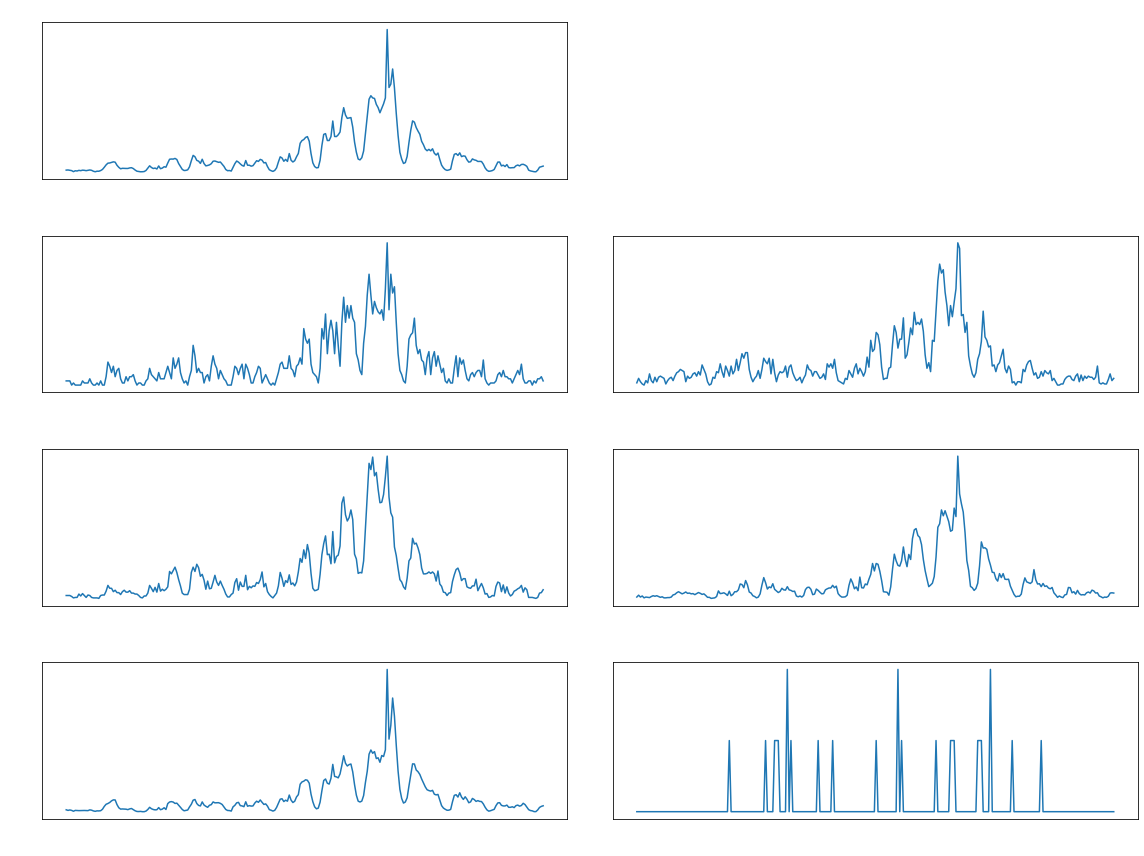

In [45]:
fig = plt.figure()
#add_subplot()でグラフを描画する領域を追加する．引数は行，列，場所
ax1 = fig.add_subplot(4, 2, 1)
ax2 = fig.add_subplot(4, 2, 3)
ax3 = fig.add_subplot(4, 2, 4)
ax4 = fig.add_subplot(4, 2, 5)
ax5 = fig.add_subplot(4, 2, 6)
ax6 = fig.add_subplot(4, 2, 7)
ax7 = fig.add_subplot(4, 2, 8)

t = xlabel_hour
y1 = tweet_nums_per_hour
y2 = tweet_nums_per_hour_lon_to_130
y3 = tweet_nums_per_hour_lon_to_133
y4 = tweet_nums_per_hour_lon_to_136
y5 = tweet_nums_per_hour_lon_to_139
y6 = tweet_nums_per_hour_lon_to_142
y7 = tweet_nums_per_hour_lon_over_145

y1 = scipy.stats.zscore(y1)
y2 = scipy.stats.zscore(y2)
y3 = scipy.stats.zscore(y3)
y4 = scipy.stats.zscore(y4)
y5 = scipy.stats.zscore(y5)
y6 = scipy.stats.zscore(y6)
y7 = scipy.stats.zscore(y7)

ax1.plot(t, y1)
ax2.plot(t, y2)
ax3.plot(t, y3)
ax4.plot(t, y4)
ax5.plot(t, y5)
ax6.plot(t, y6)
ax7.plot(t, y7)


ax1.tick_params(direction = "inout", length = 5, colors = "white")
#repeate_code
ax1.set_title("lon_under_130",color="white")
ax1.set_xticks(np.arange(0, 264, 24))
ax1.set_xlabel("time",color="white")
ax1.set_ylabel("sum_tweets",color="white")

ax2.tick_params(direction = "inout", length = 5, colors = "white")
#repeate_code
ax2.set_title("130to133",color="white")
ax2.set_xticks(np.arange(0, 264, 24))
ax2.set_xlabel("time",color="white")
ax2.set_ylabel("sum_tweets",color="white")

ax3.tick_params(direction = "inout", length = 5, colors = "white")
#repeate_code
ax3.set_title("133to136",color="white")
ax3.set_xticks(np.arange(0, 264, 24))
ax3.set_xlabel("time",color="white")
ax3.set_ylabel("sum_tweets",color="white")

ax4.tick_params(direction = "inout", length = 5, colors = "white")
#repeate_code
ax4.set_title("136to139",color="white")
ax4.set_xticks(np.arange(0, 264, 24))
ax4.set_xlabel("time",color="white")
ax4.set_ylabel("sum_tweets",color="white")

ax5.tick_params(direction = "inout", length = 5, colors = "white")
#repeate_code
ax5.set_title("139to142",color="white")
ax5.set_xticks(np.arange(0, 264, 24))
ax5.set_xlabel("time",color="white")
ax5.set_ylabel("sum_tweets",color="white")

ax6.tick_params(direction = "inout", length = 5, colors = "white")
#repeate_code
ax6.set_title("142to145",color="white")
ax6.set_xticks(np.arange(0, 264, 24))
ax6.set_xlabel("time",color="white")
ax6.set_ylabel("sum_tweets",color="white")

ax7.tick_params(direction = "inout", length = 5, colors = "white")
#repeate_code
ax7.set_title("over_145",color="white")
ax7.set_xticks(np.arange(0, 264, 24))
ax7.set_xlabel("time",color="white")
ax7.set_ylabel("sum_tweets",color="white")

fig.tight_layout()              #レイアウトの設定
plt.show()